# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

TF-MoDISco is using the TensorFlow backend.


3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already
File test.txt.gz exists already


### Functions for one-hot encoding sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

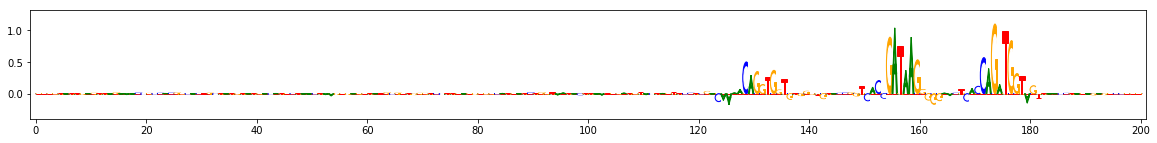

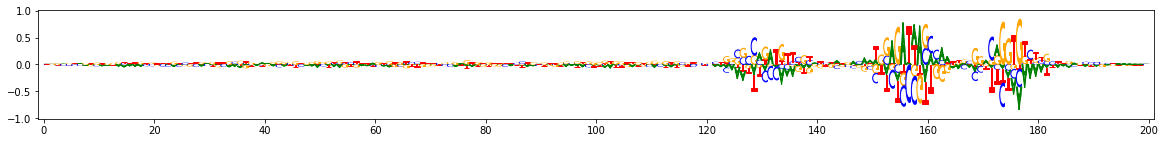

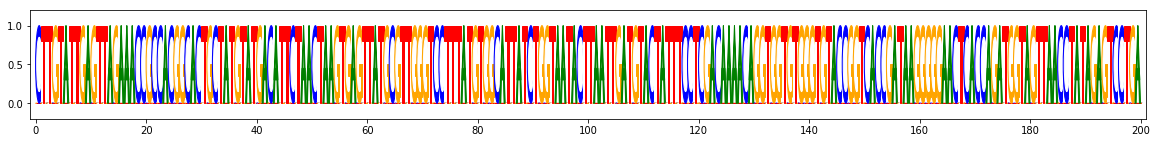

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size `sliding_window_size` and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see `examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb` for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that `target_seqlet_fdr`. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -1.0124836564064026  and  0.8997364044189453
Final raw thresholds are -1.0124836564064026  and  0.8997364044189453
Final transformed thresholds are -0.8494086021505376  and  0.8402150537634409


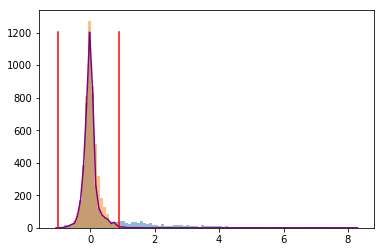

Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Computing threshold
Thresholds from null dist were -0.918197512626648  and  0.608733057975769
Final raw thresholds are -0.918197512626648  and  0.608733057975769
Final transformed thresholds are -0.9040322580645161  and  0.8833870967741936


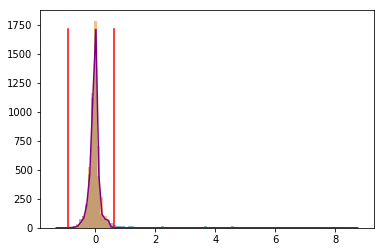

Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Computing threshold
Thresholds from null dist were -0.6213091909885406  and  0.6281718015670776
Final raw thresholds are -0.6213091909885406  and  0.6281718015670776
Final transformed thresholds are -0.8680107526881721  and  0.8682795698924731


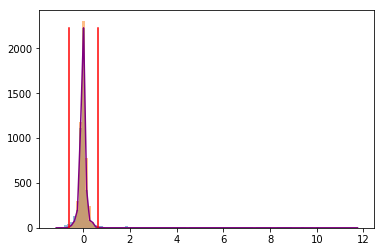

Got 166 coords
After resolving overlaps, got 275 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8402149537634409
275 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [115, 104]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
On metacluster 1
Metacluster size 104
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)


W0704 17:48:06.785071 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/Research/modisco/modisco/backend/tensorflow_backend.py:87: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 104
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings


Using TensorFlow backend.
W0704 17:48:07.318926 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0704 17:48:07.319909 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0704 17:48:07.320613 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0704 17:48:07.323328 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_

Finished embedding computation in 0.37 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 3.93 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.38 s
(Round 1) Computed affinity matrix on nearest neighbors in 4.4 s
Filtered down to 98 of 104
(Round 1) Retained 98 rows out of 104 after filtering
(Round 1) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 98 samples in 0.000s...
[t-SNE] Computed neighbors for 98 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 98 / 98
[t-SNE] Mean sigma: 0.225730
(Round 1) C

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.636291742324829 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished


Wrote graph to binary file in 0.014899015426635742 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.703462
Louvain completed 51 runs in 0.7559549808502197 seconds
Preproc + Louvain took 2.4571738243103027 s
Got 7 clusters after round 1
Counts:
{6: 5, 2: 16, 1: 16, 4: 12, 0: 26, 3: 14, 5: 9}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 26 seqlets
Trimmed 0 out of 26
Skipped 6 seqlets
Aggregating for cluster 1 with 16 seqlets
Trimmed 0 out of 16
Skipped 1 seqlets
Aggregating for cluster 2 with 16 seqlets
Trimmed 1 out of 16
Aggregating for cluster 3 with 14 seqlets
Trimmed 0 out of 14
Skipped 2 seqlets
Aggregating for cluster 4 with 12 seqlets
Trimmed 0 out of 12
Skipped 2 seqlets
Aggregating for cluster 5 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 6 with 5 seqlets
Trimmed 0 out of 5
(Round 2) num seqlets: 86
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finish

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.6436121463775635 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished


Wrote graph to binary file in 0.00917816162109375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.715433
After 3 runs, maximum modularity is Q = 0.725825
After 17 runs, maximum modularity is Q = 0.726544
Louvain completed 67 runs in 1.0044641494750977 seconds
Preproc + Louvain took 2.7107152938842773 s
Got 8 clusters after round 2
Counts:
{0: 26, 5: 9, 1: 15, 7: 2, 2: 12, 4: 10, 3: 10, 6: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 26 seqlets
Trimmed 5 out of 26
Aggregating for cluster 1 with 15 seqlets
Trimmed 1 out of 15
Aggregating for cluster 2 with 12 seqlets
Trimmed 1 out of 12
Aggregating for cluster 3 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 4 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 5 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 6 with 2 seqlets
Trimmed 0 out of 2
Aggregating for cluster 7 with 2 seqlets
Trimmed 0 out of 2
Got 8 clusters
Splitting in

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.6228461265563965 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished


Wrote graph to binary file in 0.016069889068603516 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.714045
Louvain completed 51 runs in 0.7631368637084961 seconds
Preproc + Louvain took 2.451098918914795 s
Got 6 clusters after round 1
Counts:
{4: 16, 2: 23, 3: 17, 0: 25, 1: 25, 5: 3}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 25 seqlets
Trimmed 0 out of 25
Skipped 3 seqlets
Aggregating for cluster 1 with 25 seqlets
Trimmed 0 out of 25
Skipped 7 seqlets
Aggregating for cluster 2 with 23 seqlets
Trimmed 3 out of 23
Skipped 3 seqlets
Aggregating for cluster 3 with 17 seqlets
Trimmed 0 out of 17
Skipped 2 seqlets
Aggregating for cluster 4 with 16 seqlets
Trimmed 0 out of 16
Skipped 2 seqlets
Aggregating for cluster 5 with 3 seqlets
Trimmed 0 out of 3
(Round 2) num seqlets: 88
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.02 s
Starting affin

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.7167561054229736 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished


Wrote graph to binary file in 0.013947010040283203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.74049
After 26 runs, maximum modularity is Q = 0.746432
Louvain completed 76 runs in 1.1371979713439941 seconds
Preproc + Louvain took 2.9229609966278076 s
Got 5 clusters after round 2
Counts:
{3: 16, 4: 14, 2: 16, 0: 26, 1: 16}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 26 seqlets
Trimmed 0 out of 26
Aggregating for cluster 1 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 2 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 3 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 4 with 14 seqlets
Trimmed 0 out of 14
Got 5 clusters
Splitting into subclusters...
Merging on 5 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 2 with prob 0.0009108167401644766 and sim 1.9652150175151029
Collapsing 2 & 4 with prob 1.04

In [7]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0", "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [8]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results

Metaclusters heatmap


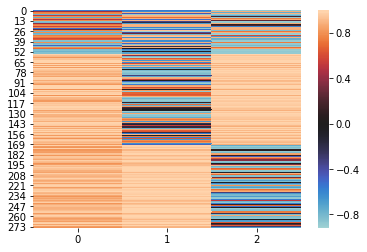

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 85
Task 0 hypothetical scores:


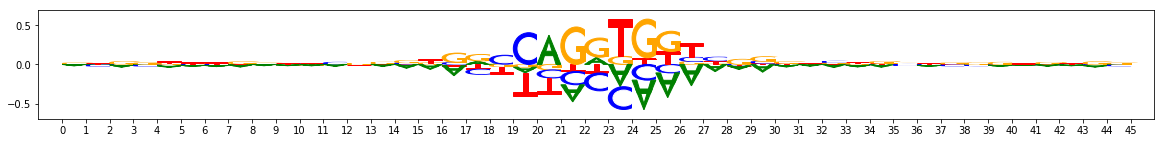

Task 0 actual importance scores:


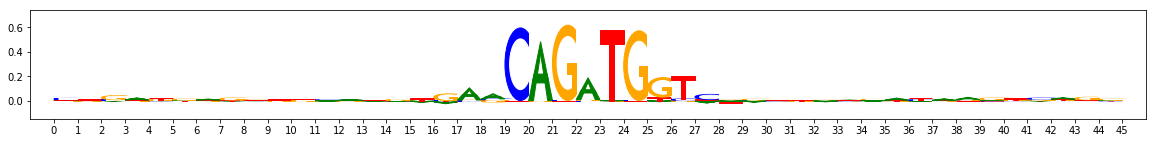

Task 1 hypothetical scores:


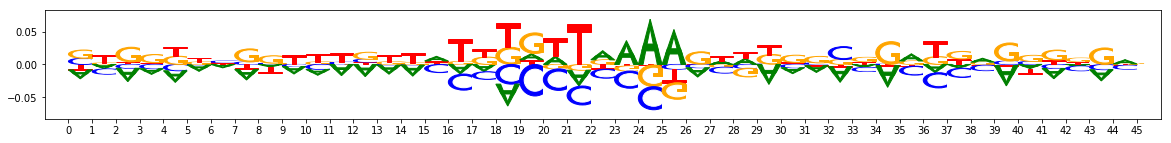

Task 1 actual importance scores:


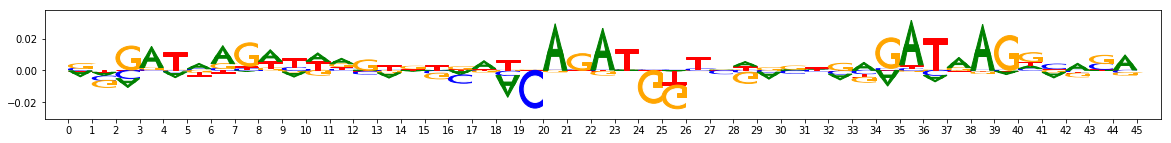

Task 2 hypothetical scores:


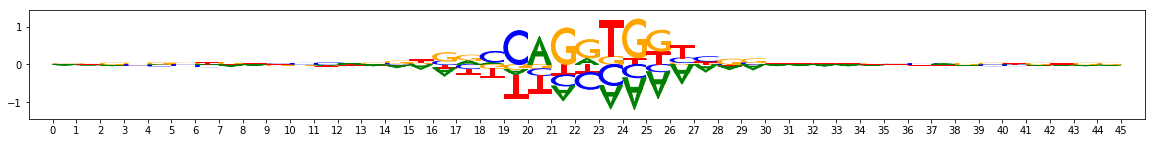

Task 2 actual importance scores:


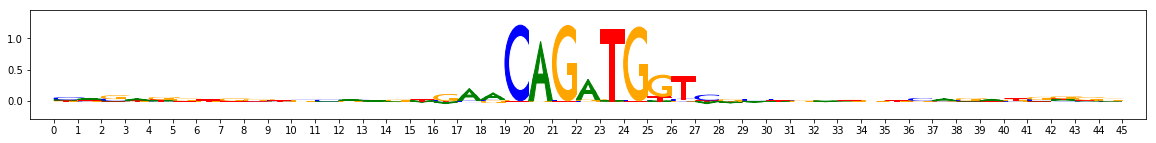

onehot, fwd and rev:


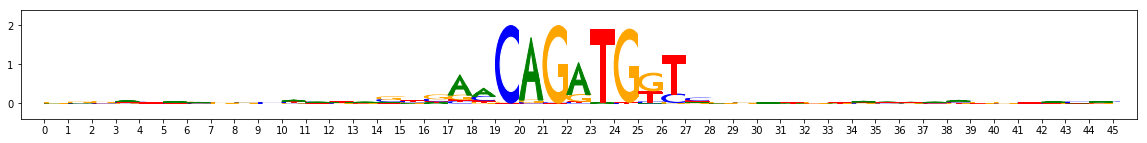

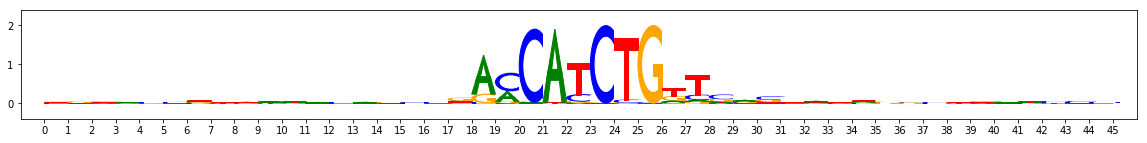

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 67
Task 0 hypothetical scores:


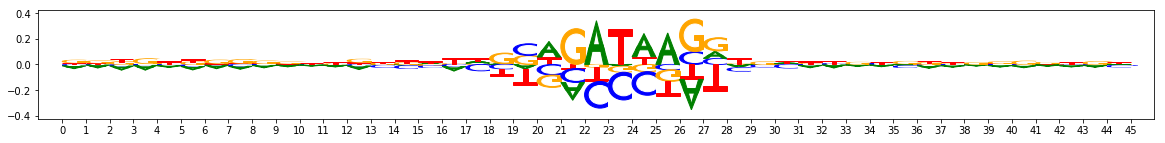

Task 0 actual importance scores:


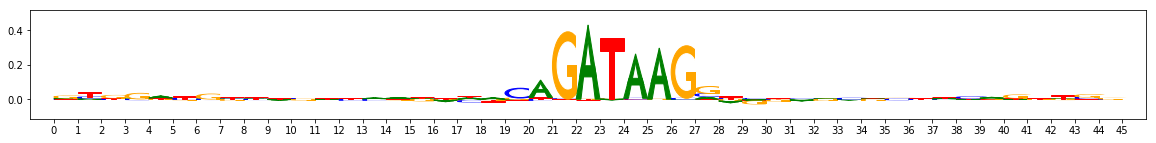

Task 1 hypothetical scores:


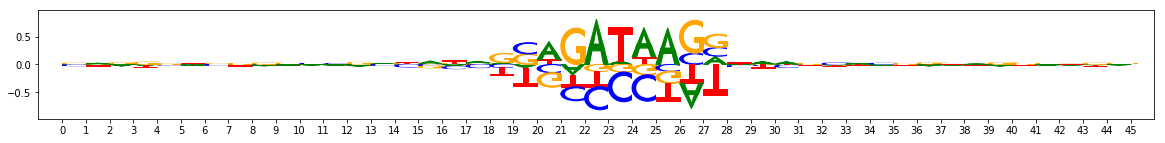

Task 1 actual importance scores:


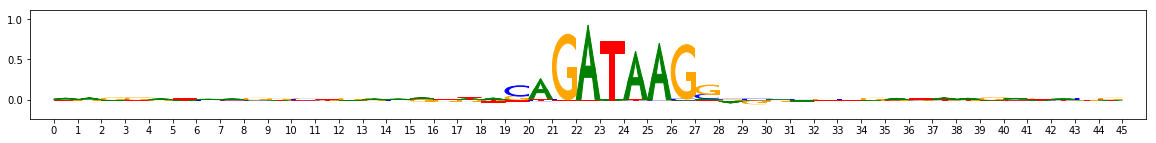

Task 2 hypothetical scores:


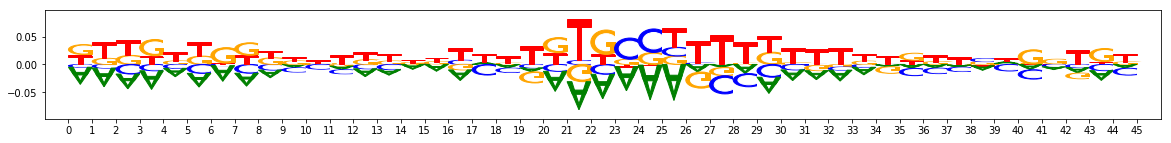

Task 2 actual importance scores:


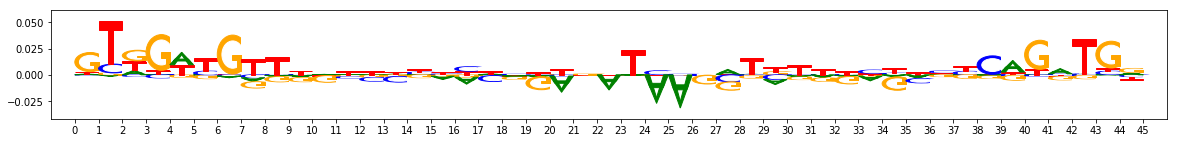

onehot, fwd and rev:


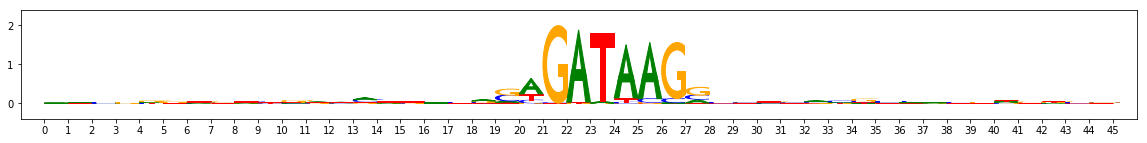

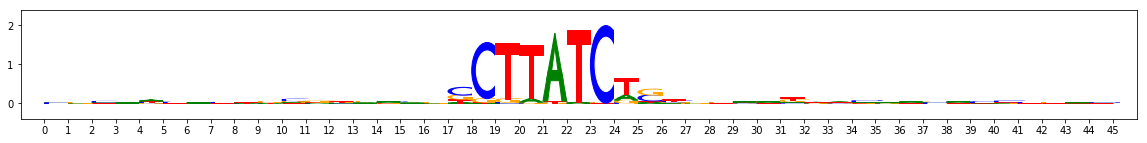

In [9]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file

Load the results object from the saved file

In [10]:
import h5py
import numpy as np
from collections import OrderedDict
import modisco.util
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow
reload(workflow)

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

## Prepare hit scorers

Prepare a seqlet scorer (`max_rank_based_pattern_scorer`)

In [11]:
from modisco import affinitymat
reload(affinitymat.core)
reload(affinitymat)
from modisco import hit_scoring
reload(hit_scoring.fast_hit_scoring)
reload(hit_scoring)
from collections import OrderedDict

task_names = ["task0", "task1", "task2"]

seqlet_size_to_score_with = 25

metacluster_idx_to_scorer = OrderedDict()

all_pattern_scorers = []
all_pattern_names = []

for metacluster_name in\
    sorted(loaded_tfmodisco_results
           .metacluster_idx_to_submetacluster_results.keys()):
    submetacluster_results =(
        loaded_tfmodisco_results
            .metacluster_idx_to_submetacluster_results[metacluster_name])
    activity_pattern = submetacluster_results.activity_pattern
    relevant_task_names = [task_name for (task_name,x) in
                           zip(task_names, activity_pattern) if np.abs(x) != 0]
    
    patterns_in_submetacluster =\
        submetacluster_results.seqlets_to_patterns_result.patterns
 
    pattern_comparison_settings = affinitymat.core.PatternComparisonSettings(
        track_names=([x+"_contrib_scores" for x in relevant_task_names]
                     +[x+"_hypothetical_contribs" for x in relevant_task_names]),
        track_transformer=affinitymat.L1Normalizer(),
        min_overlap=0.7)

    pattern_to_seqlets_sim_computer = hit_scoring.PatternsToSeqletsSimComputer(
        pattern_comparison_settings=pattern_comparison_settings,
        cross_metric_computer=\
            affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=1,
                cross_metric_single_region=
                    affinitymat.core.CrossContinJaccardSingleRegionWithArgmax(),
                verbose=False),
        seqlet_trimmer=modisco.hit_scoring.SeqletTrimToBestWindow(
                        window_size=seqlet_size_to_score_with,
                        track_names=[x+"_contrib_scores" for x
                                     in relevant_task_names]))

    #Get a list of scorers for all the patterns in the metacluster
    metacluster_pattern_scorers = []
    for pattern_idx, pattern in\
        enumerate(submetacluster_results.
                   seqlets_to_patterns_result.patterns):
        metacluster_idx = int(metacluster_name.split("_")[1])
        all_pattern_names.append("metacluster_"+str(metacluster_idx)
                             +",pattern_"+str(pattern_idx))
        pattern_scorer = hit_scoring.RankBasedPatternScorer(
                aggseqlets=pattern,
                patterns_to_seqlets_sim_computer=
                    pattern_to_seqlets_sim_computer)
        metacluster_pattern_scorers.append(pattern_scorer)
        all_pattern_scorers.append(pattern_scorer)
    #This is the final scorer for the metacluster;
    # it takes the maximum score produced by all the
    # individual scorers
    max_rank_based_pattern_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                        pattern_scorers=metacluster_pattern_scorers)
    metacluster_idx_to_scorer[metacluster_idx] = max_rank_based_pattern_scorer
cross_metacluster_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                pattern_scorers=all_pattern_scorers)

Test it out...prepare a bunch of seqlets to score using the original patterns

In [12]:
from sklearn.metrics import confusion_matrix
all_patterns = [x for y in
                  sorted(loaded_tfmodisco_results
                  .metacluster_idx_to_submetacluster_results.keys())
                  for x in
                   loaded_tfmodisco_results
                   .metacluster_idx_to_submetacluster_results[y]
                   .seqlets_to_patterns_result.patterns]
seqlets_to_score = []
seqlets_to_score_true_labels = []
for i,pattern in enumerate(all_patterns):
    seqlets_to_score.extend(pattern.seqlets)
    seqlets_to_score_true_labels.extend(
        [i for x in pattern.seqlets])

Now score the seqlets (we will use the cross-metacluster scorer here)

In [13]:
pattern_scores_for_each_seqlet = cross_metacluster_scorer(seqlets_to_score)
print(pattern_scores_for_each_seqlet[:5])
seqlets_to_score_predicted_labels =\
    [x.pattern_idx for x in pattern_scores_for_each_seqlet]
confusion_mat = confusion_matrix(y_true = seqlets_to_score_true_labels,
                                 y_pred = seqlets_to_score_predicted_labels)
print(all_pattern_names)
print(confusion_mat.astype("float")/np.sum(confusion_mat,axis=1)[:,None])

[RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9882352941176471, score=0.647792627712641, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.8941176470588236, score=0.6252278860805056, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.8588235294117647, score=0.6133278732521176, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.6470588235294118, score=0.561951696826899, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.2, score=0.4410259616948501, offset=0.0, revcomp=0.0)]
['metacluster_0,pattern_0', 'metacluster_1,pattern_0']
[[0.97647059 0.02352941]
 [0.01492537 0.98507463]]


## Obtain seqlets from data

In [14]:
per_position_contrib_scores = OrderedDict([                             
    (x, [np.sum(s,axis=1) for s in task_to_scores[x]]) for x in tasks])
seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track=per_position_contrib_scores,  
        null_tracks=null_per_pos_scores,
        track_set=track_set,
        task_name_to_tnt_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_tnt_results,
        )).final_seqlets

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Got 166 coords
After resolving overlaps, got 275 seqlets


## Map seqlets to metacluster, then to a pattern

Example seqlets for metacluster -1 (unmapped)


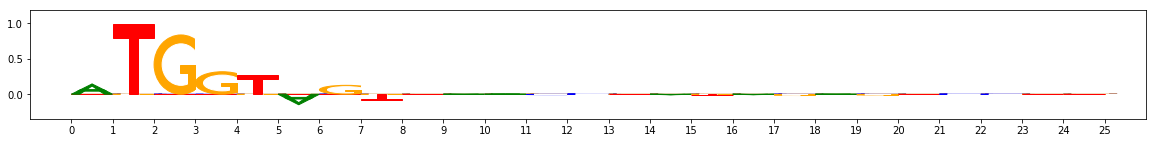

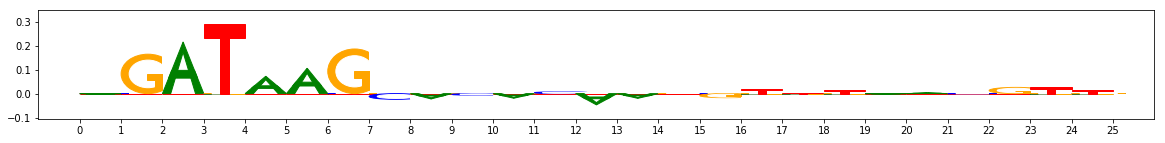


Metacluster idx 0 

TOP MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=1.0, score=0.6500150672313264, offset=12.0, revcomp=0.0)


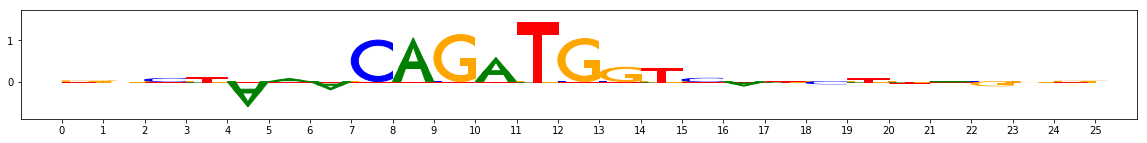

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9882352941176471, score=0.6451990341998752, offset=7.0, revcomp=0.0)


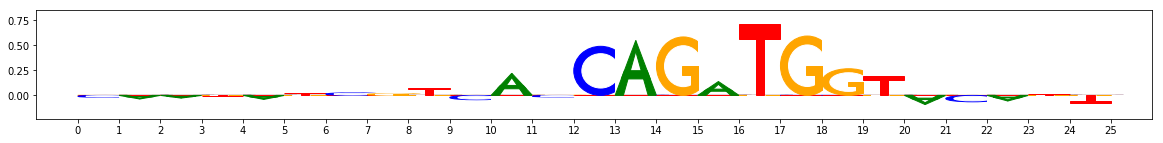

WORST MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=0.0, score=0.16729788048785413, offset=9.0, revcomp=0.0)


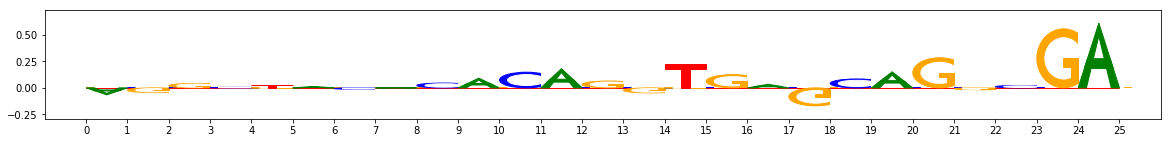

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.011764705882352941, score=0.2586371117138951, offset=9.0, revcomp=0.0)


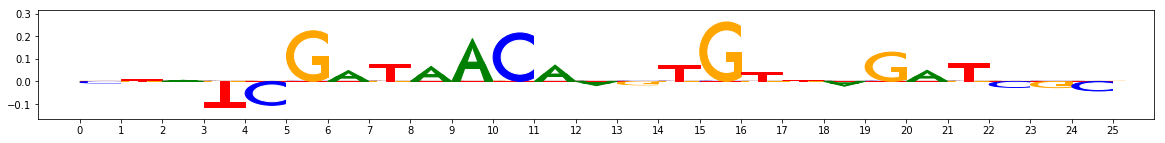


Metacluster idx 1 

TOP MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=1.0, score=0.6324580755380881, offset=14.0, revcomp=0.0)


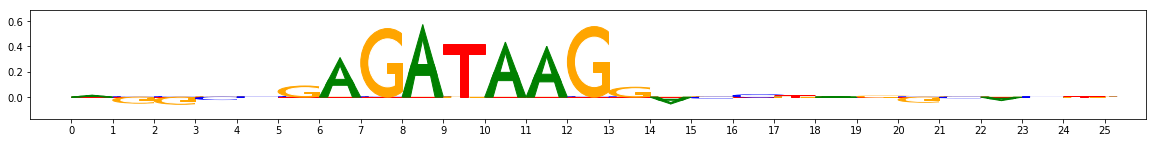

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9850746268656716, score=0.6260652347950822, offset=8.0, revcomp=0.0)


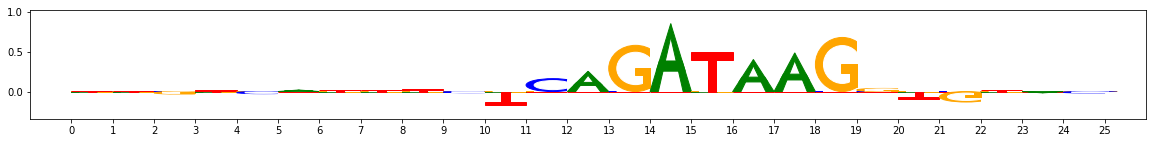

WORST MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=0.029850746268656716, score=0.23936705204277403, offset=8.0, revcomp=0.0)


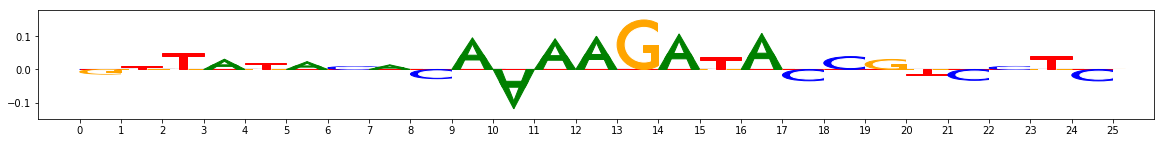

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.029850746268656716, score=0.21688285931959103, offset=22.0, revcomp=0.0)


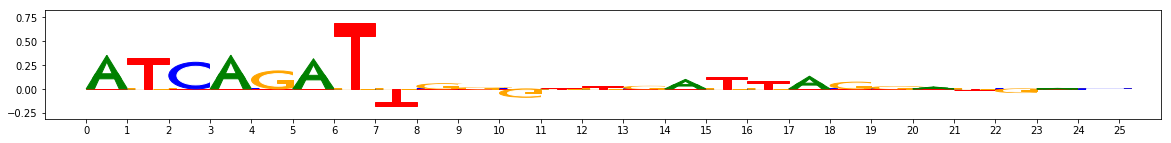

In [15]:
from collections import defaultdict, OrderedDict

metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    seqlets_from_data).metacluster_indices

metacluster_idx_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(seqlets_from_data, metacluster_indices):
    metacluster_idx_to_seqlets[metacluster_idx].append(a_seqlet)

#visualize a few seqlets from each metacluster
num_to_viz = 2
for metacluster_idx in metacluster_idx_to_seqlets:
    if (metacluster_idx == -1):
        print("Example seqlets for metacluster -1 (unmapped)")
        for a_seqlet in metacluster_idx_to_seqlets[metacluster_idx][:num_to_viz]:
            viz_sequence.plot_weights(a_seqlet["task0_contrib_scores"].fwd)

#map to patterns within each metacluster
metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    print("\nMetacluster idx",metacluster_idx,"\n")
    metacluster_seqlets = metacluster_idx_to_seqlets[metacluster_idx]
    seqlet_pattern_matches = metacluster_idx_to_scorer[metacluster_idx](metacluster_seqlets)
    metacluster_to_seqlet_pattern_matches[metacluster_idx] = seqlet_pattern_matches
    sorted_seqlet_pattern_matches = sorted(zip(seqlet_pattern_matches, metacluster_seqlets),
                                           key=lambda x: -x[0].percnormed_score)
    print("TOP MATCHES")
    for i in range(num_to_viz):
        print(sorted_seqlet_pattern_matches[i][0])
        viz_sequence.plot_weights(sorted_seqlet_pattern_matches[i][1]["task0_contrib_scores"].fwd)
    print("WORST MATCHES")
    for i in range(num_to_viz):
        print(sorted_seqlet_pattern_matches[-(i+1)][0])
        viz_sequence.plot_weights(sorted_seqlet_pattern_matches[-(i+1)][1]["task0_contrib_scores"].fwd)
        

The code below is a test to check that reverse complements also work

In [16]:
#The rc_track_set and rc_seqlets_from_data is just there to
# test whether reverse complements are working correctly
rc_track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=dict([(key, np.array(val)[:,::-1,::-1]) for
                                     (key,val) in task_to_scores.items()]),
                hypothetical_contribs=dict([(key, np.array(val)[:,::-1,::-1]) for
                                            (key,val) in task_to_hyp_scores.items()]),
                one_hot=onehot_data)
rc_seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track={key: np.array(val)[:,::-1] for
                                  (key,val) in per_position_contrib_scores.items()},
        null_tracks=null_per_pos_scores,
        track_set=rc_track_set,
        task_name_to_tnt_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_tnt_results)).final_seqlets

rc_metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    rc_seqlets_from_data).metacluster_indices
assert np.max(np.abs(np.array(rc_metacluster_indices)
                     - np.array(metacluster_indices)))==0

rc_metacluster_idx_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(rc_seqlets_from_data, rc_metacluster_indices):
    rc_metacluster_idx_to_seqlets[metacluster_idx].append(a_seqlet)

#map to patterns within each metacluster
rc_metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    rc_metacluster_to_seqlet_pattern_matches[metacluster_idx] =\
        metacluster_idx_to_scorer[metacluster_idx](rc_metacluster_idx_to_seqlets[metacluster_idx])
        
#check that the scores are compatible
for metacluster_idx in rc_metacluster_to_seqlet_pattern_matches:
    rc_seqlet_pattern_matches = rc_metacluster_to_seqlet_pattern_matches[metacluster_idx]
    seqlet_pattern_matches = metacluster_to_seqlet_pattern_matches[metacluster_idx]
    for (rc_match, fwd_match) in zip(rc_seqlet_pattern_matches, seqlet_pattern_matches):
        #atol = 0.02 because small numerical differences in the match score
        # can shif the percentile ranking around
        if (np.isclose(rc_match.percnormed_score,fwd_match.percnormed_score,atol=0.02) == False):
            print(rc_match, fwd_match)
            assert False
        assert np.isclose(rc_match.score, fwd_match.score)
        #In the revcomp case,
        # the value of the offset would be the same as the fwd's distance
        # from the end of the seqlet to the end of the pattern.
        # At the time of writing, 45 bp was the length of the pattern and
        # 25 bp was the length of the seqlet; 45 - (offset + 25) = 20-offset
        assert rc_match.offset == 20-fwd_match.offset
        assert rc_match.revcomp == 1.0
        assert fwd_match.revcomp == 0.0

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02277598714828491
Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0002551083639264107
Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= 0.006824198871850967
Got 166 coords
After resolving overlaps, got 275 seqlets
